# Employee Attrition Modeling

## Objective
Build and compare multiple predictive models for employee attrition using a
feature-engineered, leakage-safe dataset.

This notebook focuses on:
- Stratified train/test splitting
- Cross-validated model comparison
- Recall-oriented evaluation for attrition cases
- Technical and business interpretation of results

In [ ]:
import pandas as pd

data_path = "../data/processed/hr_employee_attrition_features.csv"

df = pd.read_csv(data_path)

df.shape

(1470, 49)

In [6]:
df.head(3)

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,early_tenure_flag,new_hire_flag,long_distance_flag,low_income_and_overtime,early_tenure_and_overtime,new_hire_and_overtime,frequent_travel_and_overtime,travel_intensity,engagement_index,AttritionFlag
0,41,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,...,0,0,0,0,0,0,0,1,2.2,1
1,49,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,...,0,0,0,0,0,0,0,2,2.8,0
2,37,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,...,1,1,0,1,1,1,0,1,2.8,1


## 2. Target Definition and Train/Test Split

We separate the target variable and perform a stratified train/test split
to preserve the original attrition distribution.

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["AttritionFlag"])
y = df["AttritionFlag"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=42,
    stratify=y,
)

y.value_counts(normalize=True), y_train.value_counts(
    normalize=True
), y_test.value_counts(normalize=True), X_train.shape, X_test.shape

(AttritionFlag
 0    0.838776
 1    0.161224
 Name: proportion, dtype: float64,
 AttritionFlag
 0    0.838435
 1    0.161565
 Name: proportion, dtype: float64,
 AttritionFlag
 0    0.840136
 1    0.159864
 Name: proportion, dtype: float64,
 (1176, 48),
 (294, 48))

## 3. Preprocessing Setup

Before modeling, we identify categorical and numerical feature groups.
These groups will be used consistently across all models to ensure a fair
comparison.

In [8]:
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

len(cat_cols), len(num_cols), cat_cols

(7,
 41,
 ['BusinessTravel',
  'Department',
  'EducationField',
  'Gender',
  'JobRole',
  'MaritalStatus',
  'OverTime'])

## 4. Preprocessing Pipeline

Numerical features are standardized, while categorical features are
one-hot encoded. Preprocessing is fitted on the training data only
and reused across all models.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="drop",
)

preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


## 5. Baseline Model: Logistic Regression

We start with Logistic Regression as a transparent baseline model.
Class weighting is used to address class imbalance.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

log_reg = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)

pipe_lr = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        ("model", log_reg),
    ]
)

pipe_lr

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 6. Cross-Validation Evaluation (Logistic Regression)

We evaluate the baseline model using stratified cross-validation.
Primary metric: ROC-AUC  
Secondary metrics: Recall and Precision for attrition cases.

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_validate

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "roc_auc": "roc_auc",
    "recall": "recall",
    "precision": "precision",
}

cv_lr = cross_validate(
    pipe_lr,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False,
)

{
    metric: (cv_lr[f"test_{metric}"].mean(), cv_lr[f"test_{metric}"].std())
    for metric in scoring
}

{'roc_auc': (np.float64(0.822371052226783), np.float64(0.02083945717886691)),
 'recall': (np.float64(0.7105263157894737), np.float64(0.07806524723258591)),
 'precision': (np.float64(0.3856507936507937),
  np.float64(0.03718781704345586))}

## 7. Test Set Evaluation (Logistic Regression)

The trained pipeline is evaluated on the held-out test set to assess
generalization performance.

In [16]:
from sklearn.metrics import roc_auc_score, classification_report

# Fit model on full training set
pipe_lr.fit(X_train, y_train)

# Predict probabilities and classes
y_test_proba = pipe_lr.predict_proba(X_test)[:, 1]
y_test_pred = pipe_lr.predict(X_test)

# Metrics
test_roc_auc = roc_auc_score(y_test, y_test_proba)

test_roc_auc

0.8354724782496339

In [17]:
classification_report(y_test, y_test_pred)

'              precision    recall  f1-score   support\n\n           0       0.92      0.79      0.85       247\n           1       0.38      0.66      0.48        47\n\n    accuracy                           0.77       294\n   macro avg       0.65      0.73      0.67       294\nweighted avg       0.84      0.77      0.79       294\n'

## 8. Leakage Sanity Checks

We run quick sanity checks to confirm there is no train/test overlap and
no target leakage through unintended features.

In [18]:
# 1) Row overlap check (requires unique identifier; EmployeeNumber was dropped earlier)
# We use full-row hashing as a proxy check.
train_hash = pd.util.hash_pandas_object(X_train, index=False)
test_hash = pd.util.hash_pandas_object(X_test, index=False)

overlap_count = len(set(train_hash).intersection(set(test_hash)))

# 2) Target leakage check: ensure target is not present among features
target_in_features = "AttritionFlag" in X_train.columns

overlap_count, target_in_features

(0, False)

## 9. Confusion Matrix (Logistic Regression)

The confusion matrix helps visualize the trade-off between recall and
precision for attrition cases.

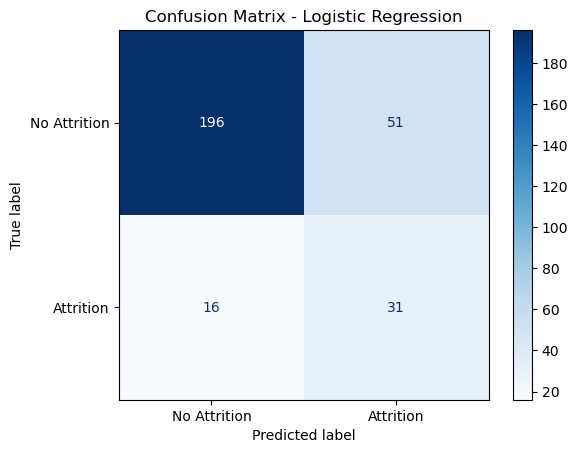

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["No Attrition", "Attrition"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

### Logistic Regression Summary (Baseline)

- Test ROC-AUC: 0.835
- Attrition (1) recall: 0.66 (31 of 47 attrition cases detected)
- Attrition (1) precision: 0.38 (31 of 82 predicted attritions were correct)

Interpretation:
The baseline model provides strong ranking performance (ROC-AUC) and captures
a majority of attrition cases (recall), but at the cost of a moderate number
of false positives. This trade-off is acceptable for HR use-cases where
missing attrition cases is more costly than investigating some false alarms.

## 10. Model 2: Regularized Logistic Regression (L1 / ElasticNet)

We evaluate a regularized Logistic Regression variant to test whether
shrinkage and implicit feature selection improve generalization.

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg_l1 = LogisticRegression(
    penalty="l1", solver="saga", max_iter=3000, class_weight="balanced", random_state=42
)

pipe_lr_l1 = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        ("model", log_reg_l1),
    ]
)

pipe_lr_l1

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 11. Cross-Validation Evaluation (L1 Logistic Regression)

We use the same stratified CV procedure and metrics to ensure a fair
comparison with the baseline Logistic Regression.

In [ ]:
cv_lr_l1 = cross_validate(
    pipe_lr_l1,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False,
)

{
    metric: (cv_lr_l1[f"test_{metric}"].mean(), cv_lr_l1[f"test_{metric}"].std())
    for metric in scoring
}

{'roc_auc': (np.float64(0.8241083018267095), np.float64(0.02175627780413575)),
 'recall': (np.float64(0.7157894736842105), np.float64(0.07877173445839876)),
 'precision': (np.float64(0.38386278195488727),
  np.float64(0.03488514574567915))}

## 12) Model Evaluation on Test Set
### Logistic Regression (L1 Regularization)

In [24]:
# Fit pipeline on training data
pipe_lr_l1.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Test ROC-AUC (L1 Logistic Regression): 0.83254371608235

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.79      0.86       247
           1       0.39      0.68      0.49        47

    accuracy                           0.78       294
   macro avg       0.66      0.74      0.67       294
weighted avg       0.84      0.78      0.80       294



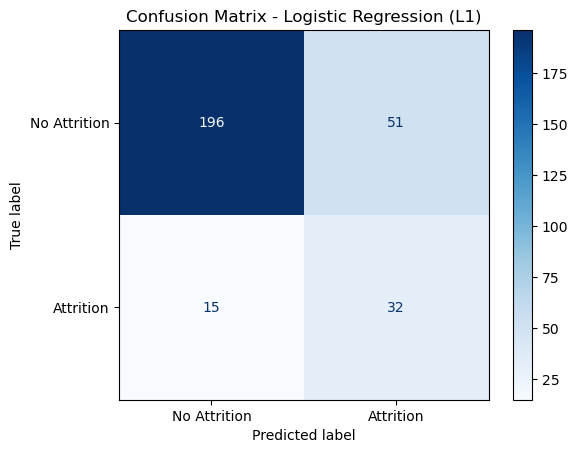

In [ ]:
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt

# Predict probabilities and labels on test set
y_test_proba_l1 = pipe_lr_l1.predict_proba(X_test)[:, 1]
y_test_pred_l1 = pipe_lr_l1.predict(X_test)

# ROC-AUC
test_roc_auc_l1 = roc_auc_score(y_test, y_test_proba_l1)

print("Test ROC-AUC (L1 Logistic Regression):", test_roc_auc_l1)
print("\nClassification Report:\n")
print(classification_report(y_test, y_test_pred_l1))

# Confusion Matrix
cm_l1 = confusion_matrix(y_test, y_test_pred_l1)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_l1, display_labels=["No Attrition", "Attrition"]
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression (L1)")
plt.show()

### Interpretation (Logistic Regression with L1 Regularization)

- Test ROC-AUC: 0.833
- Attrition (1) precision: 0.39
- Attrition (1) recall: 0.68
- Confusion matrix: TN=196, FP=51, FN=15, TP=32

Interpretation:
The L1-regularized Logistic Regression performs almost identically to the L2 baseline on the test set, with a marginal improvement in attrition recall (32 of 47 attrition cases detected). This suggests that the engineered features and the overall signal in the data are robust, and that further gains are unlikely to come from linear regularization alone.

Practical implication:
This model can be used as a strong, interpretable baseline for attrition risk scoring. However, since precision remains moderate, the output should be treated as a prioritization tool (screening high-risk employees) rather than a definitive attrition predictor.

Next step:
We will evaluate a non-linear model (Random Forest) to test whether capturing interactions and non-linear effects improves performance beyond the linear decision boundary.

## 13. L1 Sparsity Check and Top Coefficients

We inspect the fitted L1 model coefficients to verify whether L1 regularization
is performing implicit feature selection and to identify the most influential features.

In [ ]:
import numpy as np
import pandas as pd

# Get feature names after preprocessing
feature_names = pipe_lr_l1.named_steps["preprocessing"].get_feature_names_out()

coefs = pipe_lr_l1.named_steps["model"].coef_.ravel()
coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})

# Sparsity summary (how many coefficients are effectively zero)
threshold = 1e-6
n_total = coef_df.shape[0]
n_zero = (coef_df["coef"].abs() < threshold).sum()
sparsity_pct = n_zero / n_total * 100

n_total, n_zero, sparsity_pct, coef_df.reindex(
    coef_df["coef"].abs().sort_values(ascending=False).index
).head(10)

(69,
 np.int64(15),
 np.float64(21.73913043478261),
                                  feature      coef
 60        cat__JobRole_Research Director -1.610557
 63     cat__JobRole_Sales Representative  1.361830
 57    cat__JobRole_Laboratory Technician  1.130599
 40                 num__engagement_index -0.705553
 47   cat__EducationField_Human Resources  0.672065
 28                    num__overtime_flag  0.569251
 51             cat__EducationField_Other -0.525927
 39                 num__travel_intensity  0.516904
 11               num__NumCompaniesWorked  0.510317
 52  cat__EducationField_Technical Degree  0.505550)

## 14. Model 3: Random Forest Classifier

We evaluate a tree-based model to capture non-linearities and interactions
that linear models may miss. We keep the same preprocessing for a fair
comparison across models.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=500, random_state=42, class_weight="balanced", n_jobs=-1
)

pipe_rf = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        ("model", rf),
    ]
)

pipe_rf

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
from sklearn.model_selection import cross_validate

cv_metrics_rf = cross_validate(
    pipe_rf,
    X_train,
    y_train,
    cv=5,
    scoring={
        "roc_auc": "roc_auc",
        "recall": "recall",
        "precision": "precision",
    },
    n_jobs=-1,
)

{
    "roc_auc": (
        cv_metrics_rf["test_roc_auc"].mean(),
        cv_metrics_rf["test_roc_auc"].std(),
    ),
    "recall": (cv_metrics_rf["test_recall"].mean(), cv_metrics_rf["test_recall"].std()),
    "precision": (
        cv_metrics_rf["test_precision"].mean(),
        cv_metrics_rf["test_precision"].std(),
    ),
}

{'roc_auc': (np.float64(0.8052446722096736), np.float64(0.06720386738383989)),
 'recall': (np.float64(0.17368421052631577), np.float64(0.04588314677411235)),
 'precision': (np.float64(0.7768831168831168), np.float64(0.0466532118842806))}

## 15. Test Set Evaluation (Random Forest)

We evaluate the Random Forest model on the test set using the default
classification threshold of 0.5. We will later analyze alternative
thresholds to prioritize attrition recall.


In [29]:
from sklearn.metrics import roc_auc_score, classification_report

# Fit on full training set
pipe_rf.fit(X_train, y_train)

# Predict proba and labels (default threshold 0.5)
y_test_proba_rf = pipe_rf.predict_proba(X_test)[:, 1]
y_test_pred_rf = pipe_rf.predict(X_test)

test_roc_auc_rf = roc_auc_score(y_test, y_test_proba_rf)

print("Test ROC-AUC (Random Forest):", test_roc_auc_rf)
print("\nClassification Report:\n")
print(classification_report(y_test, y_test_pred_rf))

Test ROC-AUC (Random Forest): 0.7935653372383495

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.98      0.92       247
           1       0.60      0.13      0.21        47

    accuracy                           0.85       294
   macro avg       0.73      0.56      0.56       294
weighted avg       0.81      0.85      0.80       294



## 17. Confusion Matrix (Random Forest, default threshold = 0.5)

We visualize the default decision threshold behavior. The expected pattern
is high true negatives but low recall for attrition.

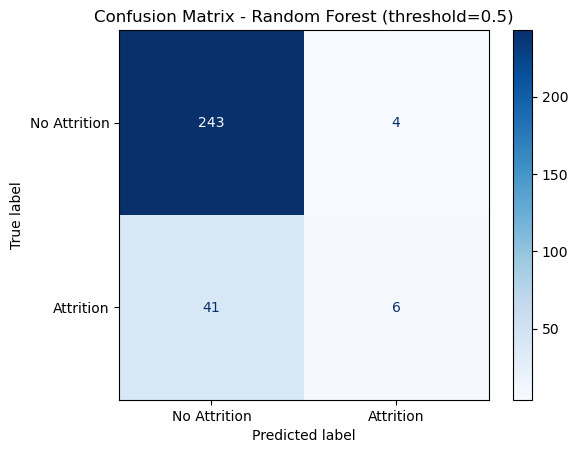

array([[243,   4],
       [ 41,   6]])

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm_rf = confusion_matrix(y_test, y_test_pred_rf)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_rf, display_labels=["No Attrition", "Attrition"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Random Forest (threshold=0.5)")
plt.show()

cm_rf

## 18. Threshold Tuning for Random Forest

We evaluate multiple probability thresholds to understand the trade-off
between recall and precision for the attrition class.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score

thresholds = np.arange(0.1, 0.9, 0.05)

rows = []

for t in thresholds:
    y_pred_t = (y_test_proba_rf >= t).astype(int)
    rows.append(
        {
            "threshold": t,
            "recall": recall_score(y_test, y_pred_t),
            "precision": precision_score(y_test, y_pred_t, zero_division=0),
        }
    )

threshold_df = pd.DataFrame(rows)
threshold_df

,threshold,recall,precision
0,0.10,0.829787,0.272727
1,0.15,0.744681,0.360825
2,0.20,0.659574,0.413333
3,0.25,0.510638,0.428571
4,0.30,0.446809,0.512195
5,0.35,0.276596,0.464286
6,0.40,0.255319,0.631579
7,0.45,0.170213,0.615385
8,0.50,0.127660,0.600000
9,0.55,0.106383,0.714286


### Interpretation (Threshold Tuning - Random Forest)

The Random Forest model is highly sensitive to the decision threshold. Lowering the threshold
substantially increases attrition recall at the expense of precision.

Key observations:
- At threshold = 0.50 (default), recall is very low (~0.13).
- At threshold = 0.20, recall improves to ~0.66 with precision ~0.41.
- At threshold = 0.15, recall reaches ~0.74 with precision ~0.36.

Given the business objective of minimizing false negatives (missing true attrition cases),
a threshold in the 0.15-0.20 range is a reasonable operating point to compare against
the Logistic Regression baselines.

## 19. Random Forest Evaluation with Tuned Threshold (t = 0.20)

We apply the selected threshold to align the model with the recall-oriented
business objective and re-evaluate performance on the test set.

Selected threshold: 0.2

Classification Report (tuned threshold):

              precision    recall  f1-score   support

           0       0.93      0.82      0.87       247
           1       0.41      0.66      0.50        47

    accuracy                           0.79       294
   macro avg       0.67      0.74      0.69       294
weighted avg       0.84      0.79      0.81       294



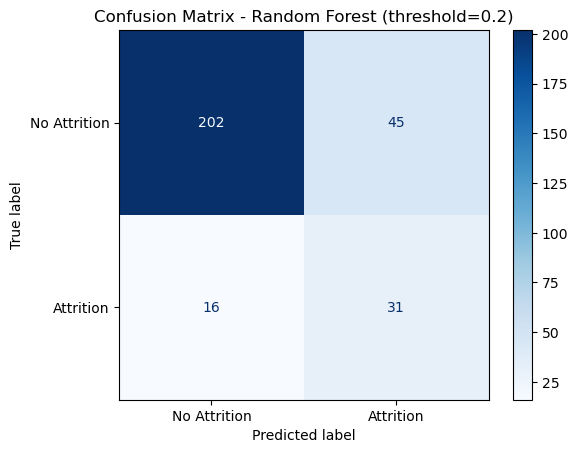

array([[202,  45],
       [ 16,  31]])

In [ ]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt

t_selected = 0.20

y_test_pred_rf_tuned = (y_test_proba_rf >= t_selected).astype(int)

print("Selected threshold:", t_selected)
print("\nClassification Report (tuned threshold):\n")
print(classification_report(y_test, y_test_pred_rf_tuned))

cm_rf_tuned = confusion_matrix(y_test, y_test_pred_rf_tuned)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_rf_tuned, display_labels=["No Attrition", "Attrition"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix - Random Forest (threshold={t_selected})")
plt.show()

cm_rf_tuned

## 20. Model 4: HistGradientBoostingClassifier

We evaluate a gradient boosting model, which often performs strongly on tabular
datasets by capturing non-linearities and feature interactions more effectively
than bagging-based models like Random Forest.

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(
    random_state=42, max_iter=300, learning_rate=0.05, max_depth=None
)

pipe_hgb = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        ("model", hgb),
    ]
)

pipe_hgb

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 21. Cross-Validation Results (HistGradientBoosting)

We run 5-fold cross-validation to estimate generalization performance and
compare against previous models using consistent metrics.

In [ ]:
from sklearn.model_selection import cross_validate

cv_metrics_hgb = cross_validate(
    pipe_hgb,
    X_train,
    y_train,
    cv=5,
    scoring={
        "roc_auc": "roc_auc",
        "recall": "recall",
        "precision": "precision",
    },
    n_jobs=-1,
)

{
    "roc_auc": (
        cv_metrics_hgb["test_roc_auc"].mean(),
        cv_metrics_hgb["test_roc_auc"].std(),
    ),
    "recall": (
        cv_metrics_hgb["test_recall"].mean(),
        cv_metrics_hgb["test_recall"].std(),
    ),
    "precision": (
        cv_metrics_hgb["test_precision"].mean(),
        cv_metrics_hgb["test_precision"].std(),
    ),
}

{'roc_auc': (np.float64(0.7850238964585745), np.float64(0.07943589223574725)),
 'recall': (np.float64(0.3052631578947368), np.float64(0.05907880084379907)),
 'precision': (np.float64(0.6294799498746867),
  np.float64(0.07906933034694179))}

## 22. Test Set Evaluation (HistGradientBoosting, threshold = 0.5)

We evaluate the gradient boosting model on the test set with the default
decision threshold (0.5) for a fair baseline comparison.

In [35]:
from sklearn.metrics import roc_auc_score, classification_report

# Fit on full training set
pipe_hgb.fit(X_train, y_train)

# Predict proba and labels (default threshold 0.5)
y_test_proba_hgb = pipe_hgb.predict_proba(X_test)[:, 1]
y_test_pred_hgb = pipe_hgb.predict(X_test)

test_roc_auc_hgb = roc_auc_score(y_test, y_test_proba_hgb)

print("Test ROC-AUC (HistGradientBoosting):", test_roc_auc_hgb)
print("\nClassification Report:\n")
print(classification_report(y_test, y_test_pred_hgb))

Test ROC-AUC (HistGradientBoosting): 0.7586355413903006

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       247
           1       0.63      0.26      0.36        47

    accuracy                           0.86       294
   macro avg       0.75      0.61      0.64       294
weighted avg       0.83      0.86      0.83       294



## 23. Confusion Matrix (HistGradientBoosting, threshold = 0.5)

We visualize the default threshold behavior to understand the balance between
false positives and false negatives for the attrition class.

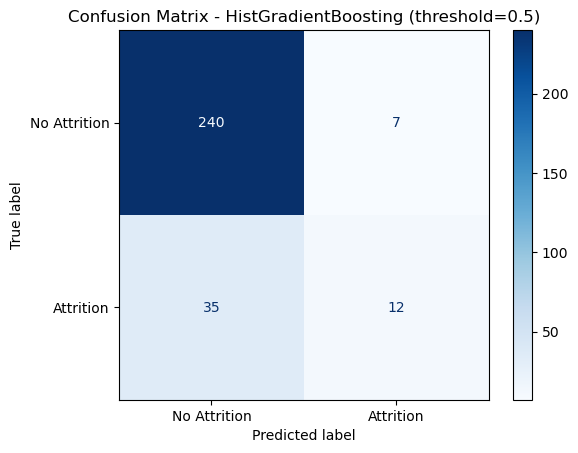

array([[240,   7],
       [ 35,  12]])

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm_hgb = confusion_matrix(y_test, y_test_pred_hgb)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_hgb, display_labels=["No Attrition", "Attrition"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - HistGradientBoosting (threshold=0.5)")
plt.show()

cm_hgb

## 24. Threshold Tuning (HistGradientBoosting)

We evaluate multiple probability thresholds to understand the recall-precision
trade-off for the attrition class and to align the model with a recall-oriented
business objective.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score

thresholds = np.arange(0.1, 0.9, 0.05)

rows = []
for t in thresholds:
    y_pred_t = (y_test_proba_hgb >= t).astype(int)
    rows.append(
        {
            "threshold": t,
            "recall": recall_score(y_test, y_pred_t),
            "precision": precision_score(y_test, y_pred_t, zero_division=0),
        }
    )

threshold_df_hgb = pd.DataFrame(rows)
threshold_df_hgb

,threshold,recall,precision
0,0.10,0.425532,0.465116
1,0.15,0.382979,0.461538
2,0.20,0.382979,0.514286
3,0.25,0.340426,0.551724
4,0.30,0.297872,0.518519
5,0.35,0.276596,0.541667
6,0.40,0.276596,0.565217
7,0.45,0.255319,0.571429
8,0.50,0.255319,0.631579
9,0.55,0.255319,0.666667


## 25. Model Comparison Summary (Test Set)

We compare the candidate models using test ROC-AUC and the attrition class
precision/recall. For tree-based models, we also report a tuned-threshold
operating point to align with recall-oriented objectives.

In [ ]:
import pandas as pd

results = [
    {
        "model": "Logistic Regression (L2, threshold=0.5)",
        "test_roc_auc": 0.8354724782496339,
        "attrition_recall": 0.6595744680851063,
        "attrition_precision": 0.38271604938271603,
    },
    {
        "model": "Logistic Regression (L1, threshold=0.5)",
        "test_roc_auc": 0.83254371608235,
        "attrition_recall": 0.6808510638297872,
        "attrition_precision": 0.3902439024390244,
    },
    {
        "model": "Random Forest (threshold=0.5)",
        "test_roc_auc": 0.7935653372383495,
        "attrition_recall": 0.1276595744680851,
        "attrition_precision": 0.60,
    },
    {
        "model": "Random Forest (threshold=0.20 tuned)",
        "test_roc_auc": 0.7935653372383495,
        "attrition_recall": 0.6595744680851063,
        "attrition_precision": 31 / (31 + 45),
    },
    {
        "model": "HistGradientBoosting (threshold=0.5)",
        "test_roc_auc": 0.7586355413903006,
        "attrition_recall": 0.2553191489361702,
        "attrition_precision": 0.631578947368421,
    },
]

results_df = pd.DataFrame(results)
results_df

,model,test_roc_auc,attrition_recall,attrition_precision
0,"Logistic Regression (L2, threshold=0.5)",0.835472,0.659574,0.382716
1,"Logistic Regression (L1, threshold=0.5)",0.832544,0.680851,0.390244
2,Random Forest (threshold=0.5),0.793565,0.127660,0.600000
3,Random Forest (threshold=0.20 tuned),0.793565,0.659574,0.407895
4,HistGradientBoosting (threshold=0.5),0.758636,0.255319,0.631579


## 26. Final Model Selection

We select **Logistic Regression (L1)** as the final model for this project.

Rationale:
- It provides the strongest overall discrimination (test ROC-AUC ~0.833), which is valuable for risk scoring and ranking employees by attrition likelihood.
- It achieves the best attrition recall among the evaluated models at the default threshold (recall ~0.681), while maintaining comparable precision to other recall-oriented operating points.
- Compared with Random Forest, it is more stable, easier to interpret, and simpler to operationalize (fewer moving parts and less sensitivity to threshold choices).

Operational note:
- Threshold tuning can still be applied later depending on business constraints (e.g., maximizing recall vs controlling false positives). For the baseline product, we keep the default threshold and focus on robust ranking performance and interpretability.

Next step:
We quantify feature impact using permutation importance to validate the contribution of both original variables and engineered features.

## 27. Permutation Importance (Logistic Regression L1)

We compute permutation importance on the test set to estimate how much each
feature contributes to predictive performance. This provides a model-agnostic
view of feature impact (including engineered features).

In [ ]:
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd

# Ensure the model is fitted (should already be, but keep it explicit)
pipe_lr_l1.fit(X_train, y_train)

perm = permutation_importance(
    pipe_lr_l1,
    X_test,
    y_test,
    n_repeats=20,
    random_state=42,
    scoring="roc_auc",
    n_jobs=-1,
)

importance_df = pd.DataFrame(
    {
        "feature": X_test.columns,
        "importance_mean": perm.importances_mean,
        "importance_std": perm.importances_std,
    }
).sort_values("importance_mean", ascending=False)

importance_df.head(20)

,feature,importance_mean,importance_std
35,overtime_flag,0.064424,0.009447
47,engagement_index,0.052472,0.016910
17,NumCompaniesWorked,0.033564,0.011297
46,travel_intensity,0.024813,0.009796
28,YearsSinceLastPromotion,0.022969,0.006371
42,low_income_and_overtime,0.020958,0.004524
40,new_hire_flag,0.017745,0.008627
37,is_single_flag,0.016539,0.005339
12,JobRole,0.013860,0.013041
24,TrainingTimesLastYear,0.013787,0.003392


## 28. Top Features by Permutation Importance

We visualize the top drivers based on permutation importance (ROC-AUC decrease),
which reflects each feature's contribution to model performance on the test set.

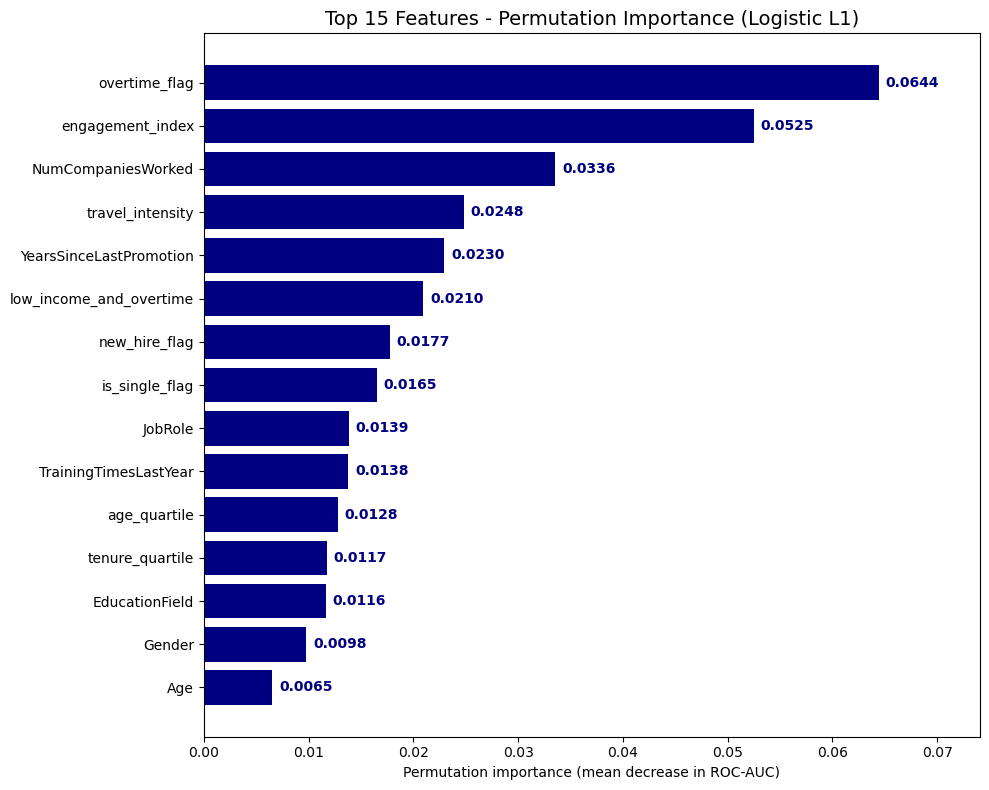

In [ ]:
import matplotlib.pyplot as plt

top_n = 15
plot_df = importance_df.head(top_n).sort_values(by="importance_mean", ascending=True)

plt.figure(figsize=(10, 8))
bars = plt.barh(plot_df["feature"], plot_df["importance_mean"], color="#000080")

for bar in bars:
    width = bar.get_width()
    plt.text(
        width + (plot_df["importance_mean"].max() * 0.01),
        bar.get_y() + bar.get_height() / 2,
        f"{width:.4f}",
        va="center",
        ha="left",
        fontsize=10,
        fontweight="bold",
        color="#000080",
    )

plt.xlabel("Permutation importance (mean decrease in ROC-AUC)")
plt.title(f"Top {top_n} Features - Permutation Importance (Logistic L1)", fontsize=14)
plt.xlim(0, plot_df["importance_mean"].max() * 1.15)
plt.tight_layout()
plt.show()

## 29. Interpretation: What Drives Attrition Risk in This Dataset

Permutation importance highlights the features that most affect ranking performance (ROC-AUC) for the final Logistic Regression (L1) model.

Key takeaways explain the attrition story in three layers:

1) Workload and intensity dominate
- `overtime_flag` is the strongest driver by a wide margin. This aligns with earlier EDA segments showing materially higher attrition among employees working overtime, especially in early tenure.

2) Engagement and stability signals matter
- `engagement_index` (a composite of ordinal satisfaction/involvement scales) ranks second, supporting the idea that the combined engagement signal is more informative than any single satisfaction score.
- `YearsSinceLastPromotion` also appears as a high-impact signal, consistent with a "career stagnation" risk pattern.

3) Mobility, transitions, and interaction effects add incremental lift
- `travel_intensity` is a top driver, reinforcing the risk associated with frequent travel.
- Engineered interactions such as `low_income_and_overtime` and `new_hire_flag` remain within the top 10, indicating that non-linear, segment-based effects identified during EDA are captured by the model.

Additional contextual drivers:
- Structural and demographic variables (`JobRole`, `EducationField`, `Gender`, `Age`, `age_quartile`, `tenure_quartile`) contribute but are not the primary levers compared with workload and engagement-related signals.

Practical implication:
In a real HR analytics setting, the most actionable levers suggested by this model are workload management (overtime exposure), early-tenure support, travel burden management, and proactive career progression pathways (promotion cadence), rather than static demographics.

## 30. Export Artifacts for Production Use

To make the project reproducible and deployable (Streamlit), we export:
- the fitted final pipeline (preprocessing + model)
- a lightweight config (feature list and default threshold)

In [43]:
from pathlib import Path

ARTIFACT_DIR = Path("../models")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

MODEL_PATH = ARTIFACT_DIR / "logreg_l1_pipeline.joblib"
CONFIG_PATH = ARTIFACT_DIR / "model_config.json"

# We will use a default decision threshold for the first Streamlit version.
DEFAULT_THRESHOLD = 0.50

MODEL_PATH, CONFIG_PATH

(WindowsPath('../models/logreg_l1_pipeline.joblib'),
 WindowsPath('../models/model_config.json'))

## 31. Fit Final Model and Persist the Pipeline

In this step, we fit the selected final model (Logistic Regression with L1 regularization)
on the training set and persist the full pipeline (preprocessing + model) for production use.

In [44]:
import joblib

# Fit final model on training set (explicit and reproducible)
pipe_lr_l1.fit(X_train, y_train)

# Save pipeline
joblib.dump(pipe_lr_l1, MODEL_PATH)

MODEL_PATH.exists(), MODEL_PATH.stat().st_size

(True, 8897)

## 32. Save Lightweight Model Configuration

We persist a lightweight configuration file to support deployment and
downstream applications (e.g., Streamlit dashboards). This config stores
model metadata, feature list, and decision threshold separately from the
trained pipeline.

In [ ]:
import json

config = {
    "model_name": "LogisticRegression_L1",
    "target": "AttritionFlag",
    "default_threshold": 0.50,
    "n_features": X_train.shape[1],
    "feature_columns": X_train.columns.tolist(),
    "notes": "Primary production model. Threshold can be tuned based on business needs.",
}

with open(CONFIG_PATH, "w", encoding="utf-8") as f:
    json.dump(config, f, indent=2)

CONFIG_PATH.exists()

True

## 33. Final Model Interpretation and Business Takeaways

### Model Choice Rationale
After evaluating multiple models (Logistic Regression L2, Logistic Regression L1,
Random Forest with threshold tuning, and HistGradientBoosting),
**Logistic Regression with L1 regularization** was selected as the final model.

This choice balances:
- Strong ranking performance (test ROC-AUC ~0.83)
- High recall for the attrition class (~0.68)
- Model stability and simplicity
- Clear interpretability for HR stakeholders
- Ease of deployment and maintenance

### Performance Summary (Test Set)
- ROC-AUC: ~0.83
- Attrition Recall: ~0.68
- Attrition Precision: ~0.39

The model intentionally prioritizes recall over precision to minimize the risk
of missing employees who are likely to leave.

### Key Drivers of Attrition
Permutation importance confirms that the model relies primarily on:
- Workload pressure (OverTime)
- Engagement signals (Engagement Index)
- Career friction (Years Since Last Promotion)
- Mobility and intensity (Travel Intensity)
- Early-tenure risk patterns combined with workload
- Compensation stress interactions

These drivers are consistent with domain knowledge and validate the
feature engineering strategy.

### Business Interpretation
The model identifies actionable high-risk employee segments, enabling:
- Early HR interventions
- Workload and travel rebalancing
- Targeted engagement and retention programs
- Proactive career development planning

### Conclusion
This solution provides a realistic, interpretable, and production-ready
attrition risk model that balances predictive performance with business
usability.

## 34. Project Wrap-Up and Future Improvements

### What This Project Demonstrates
- End-to-end data science workflow (EDA → Feature Engineering → Modeling → Evaluation)
- Thoughtful handling of class imbalance and recall–precision trade-offs
- Business-aligned model selection rather than metric chasing
- Strong emphasis on interpretability and deployment readiness

### Limitations
- Attrition is influenced by unobserved factors (manager quality, external offers,
  organizational culture) not captured in the dataset.
- Precision remains moderate due to intentional recall prioritization.
- The dataset represents a single organization context.

### Future Improvements
- Cost-sensitive learning using explicit business cost functions
- Probability calibration (Platt scaling / isotonic regression)
- Time-aware modeling if temporal data becomes available
- Integration of survey or qualitative engagement data
- Monitoring and drift detection in production

### Production Readiness
- Full preprocessing + model pipeline persisted
- Lightweight configuration stored separately
- Designed for integration into a Streamlit-based decision support tool

## 35. Transition to Modular Code Structure

To improve maintainability and reuse, the following logic will be migrated
from notebooks into modular Python scripts under the `src/` directory:

Planned structure:
- `src/data_loader.py`  
  Functions for loading raw and processed datasets

- `src/feature_engineering.py`  
  Reusable feature construction logic (flags, buckets, interaction terms)

- `src/preprocessing.py`  
  ColumnTransformer and preprocessing pipelines

- `src/modeling.py`  
  Model definitions and training utilities

- `src/inference.py`  
  Prediction and threshold application logic for deployment

This structure supports clean integration with Streamlit and future automation.